# **INTRO**

The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The acoustic_data input signal is used to predict the time remaining before the next laboratory earthquake (time_to_failure).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

acoustic_data - the seismic signal [int16]
time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]
seg_id - the test segment ids for which predictions should be made (one prediction per segment)



## **Libraries**

In [1]:
#to get kaggle datasets 
!pip install kaggle

In [2]:
!pip install numpy
#ml
!pip install catboost


## **IMPORTING LIBRARIES**

In [0]:
import pandas as pd
import numpy as np
#for ml
from catboost import CatBoostRegressor, Pool
#for preprocessing the data 
from sklearn.preprocessing import StandardScaler
#hyperparameter optimisation
from sklearn.model_selection import GridSearchCV
#for SVM
from sklearn.svm import NuSVR, SVR
#for kernal rigid model it improves the svm models 
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt


# **DataSet from kaggle**

In [13]:
#colab's file access feature
from google.colab import files
#retrive uploaded file 
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [14]:
!kaggle competitions download -c LANL-Earthquake-Prediction


seg_003339.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_0012b5.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00030f.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00648a.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00a37e.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_010eab.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_006e4a.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_004cd2.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_00e5f7.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_004314.csv: Skipping, found more recently modified local copy (use --force to force download)
seg_0042cc.csv: Skip

In [6]:
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               [y]es

catboost_info	       seg_0042cc.csv  seg_007a37.csv  seg_010eab.csv
sample_data	       seg_004314.csv  seg_00a37e.csv  seg_0125d9.csv
sample_submission.csv  seg_004cd2.csv  seg_00be11.csv  train.csv
seg_00030f.csv	       seg_004ee5.csv  seg_00c35b.csv  train.csv.zip
seg_0012b5.csv	       seg_004f1f.csv  seg_00cc91.csv
seg_00184e.csv	       seg_00648a.csv  seg_00e5f7.csv
seg_003339.csv	       seg_006e4a.csv  seg_00f3b9.csv


# **Explanotary Data Analysis**

In [7]:
#extracting the data dtypeType name or dict of column -> type, optional
train = pd.read_csv('train.csv', nrows=60000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


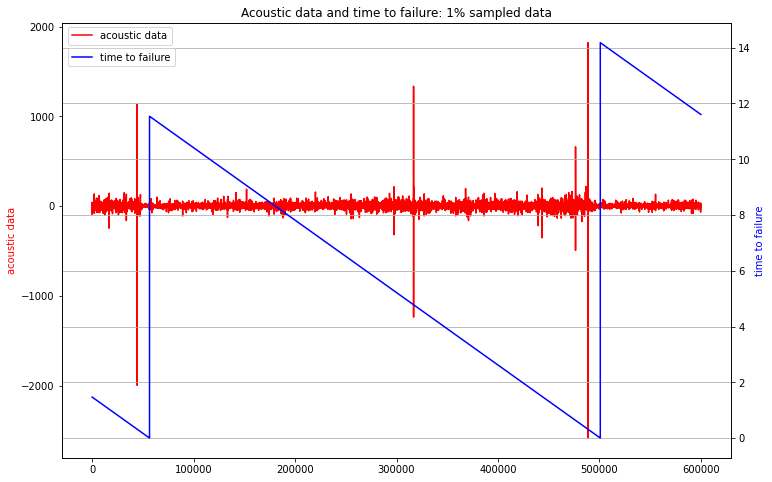

In [8]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

The inference that we get from here is that before every eathquake there is a spike in acoustic activity and thus we colclude that after every acoustic activity there is a earthquake(Siesmographic activity)

# Feature Engineeering 

In [0]:
# Feature Engineering and signifiance of these statistical features
#lets create a function to generate some statistical features based on the training data
def gen_features(X):
  strain= []
  #created an empty dataframe
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X,0.01))
  strain.append(np.quantile(X,0.05))
  strain.append(np.quantile(X,0.95))
  strain.append(np.quantile(X,0.99))
  strain.append(np.abs(X).max())
  strain.append(np.abs(X).mean())
  strain.append(np.abs(X).std())
  return pd.Series(strain)

In [10]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [11]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


# **Implement Catboost Model**

Catboost is a type of gradientboosting.
Yandex is Russian Google.
Yandex uses "gradient boosting" a lot to power their services (music streaming, search, everything really)
Gradient boosting on decision trees is a form of machine learning that works by progressively training more complex models to maximize the accuracy of predictions.
It's particularly useful for predictive models that analyze ordered (continuous) data and categorical data.
It's one of the most efficient ways to build ensemble models. The combination of gradient boosting with decision trees provides state-of-the-art results in many applications with structured data.
On the first iteration, the algorithm learns the first tree to reduce the training error, shown on left-hand image in figure 1.
This model usually has a significant error; it’s not a good idea to build very big trees in boosting since they overfit the data.
The right-hand image in figure 1 shows the second iteration, in which the algorithm learns one more tree to reduce the error made by the first tree.
The algorithm repeats this procedure until it builds a decent quality model


Gradient Boosting is a way to implement this idea for any continuous objective function.
Each step of Gradient Boosting combines two steps:
Step 1 - Computing gradients of the loss function we want to optimize for each input object
Step 2 - Learning the decision tree which predicts gradients of the loss function
ELI5 Time
Step 1 - We first model data with simple models and analyze data for errors.
Step 2 - These errors signify data points that are difficult to fit by a simple model.
Step 3 - Then for later models, we particularly focus on those hard to fit data to get them right.
Step 4 - In the end, we combine all the predictors by giving some weights to each predictor.

In [12]:
train_pool = Pool(X_train,y_train)
#number of iterations type of boosting is ordered
m=CatBoostRegressor(iterations= 100000,loss_function='MAE',boosting_type='Ordered')
m.fit(X_train,y_train,silent=True)
m.best_score_


{'learn': {'MAE': 0.6929047427804342}}

This is our first attemt we can improve upon MAE by various iterations


# **Implementing SVM**

Need to learn a nonlinear decision boundary? Grab a Kernel¶
A very simple and intuitive way of thinking about kernels (at least for SVMs) is a similarity function.

Given two objects, the kernel outputs some similarity score. The objects can be anything starting from two integers, two real valued vectors, trees whatever provided that the kernel function knows how to compare them.

The arguably simplest example is the linear kernel, also called dot-product. Given two vectors, the similarity is the length of the projection of one vector on another.

Another interesting kernel examples is Gaussian kernel. Given two vectors, the similarity will diminish with the radius of σ. The distance between two objects is "reweighted" by this radius parameter.

The success of learning with kernels (again, at least for SVMs), very strongly depends on the choice of kernel. You can see a kernel as a compact representation of the knowledge about your classification problem. It is very often problem specific.

SVM is like linear regression it takes data from the support vector boundary that we have decided

In [15]:
# we will optimize using grid search
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1719
{'C': 2, 'gamma': 0.02}
